In [145]:
import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from shared_utilities import helpers

In [146]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

GJBD-SLKK
^C



In [ ]:
session = boto3.setup_default_session(profile_name='Stellaralgo-DataScienceAdmin')

In [ ]:
conn = helpers.get_redshift_connection("qa-app", "stlrnhlpanthers")

In [ ]:
cursor = conn.cursor()
sql = "CALL ds.getretentionmodeldata(93, 2021, 2022, 'temp_cursor')"
cursor.execute(sql)

In [ ]:
temp_cursor = conn.cursor("temp_cursor")
data = temp_cursor.fetchall()

In [ ]:
df_original = pd.DataFrame(data=data, columns=[desc[0] for desc in temp_cursor.description])

In [ ]:
cursor.close()
temp_cursor.close()
conn.close()

In [ ]:
df = df_original.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5240 entries, 0 to 5239
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   lkupclientid         5240 non-null   int64         
 1   dimcustomermasterid  5240 non-null   int64         
 2   year                 5240 non-null   int64         
 3   productgrouping      5240 non-null   object        
 4   totalspent           5240 non-null   float64       
 5   recentdate           5240 non-null   datetime64[ns]
 6   attendancepercent    5240 non-null   float64       
 7   renewedbeforedays    5240 non-null   int64         
 8   source_tenure        5240 non-null   object        
 9   tenure               5240 non-null   int64         
 10  disttovenue          5240 non-null   float64       
 11  recency              5240 non-null   int64         
 12  missed_games_1       5240 non-null   object        
 13  missed_games_2       5240 non-nul

## Two Ways to check correlation

1. Numpy
2. Pandas

In [ ]:
print(np.corrcoef(df["tenure"], df["isnextyear_buyer"]))
print(df["tenure"].corr(df["isnextyear_buyer"]))

[[1.         0.28233367]
 [0.28233367 1.        ]]
0.28233367499359685


## Pearson & Spearman's correlations

In [ ]:
print(pearsonr(df["tenure"], df["isnextyear_buyer"]))
print(spearmanr(df["tenure"], df["isnextyear_buyer"]))

(0.2823336749935972, 1.2781200043963069e-96)
SpearmanrResult(correlation=0.3469361385808824, pvalue=4.267195725723516e-148)


# Cleaning and Encoding

In [ ]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [ ]:
df_encoded = encode_and_bind(df, "productgrouping")
df_encoded = encode_and_bind(df_encoded, "gender")

In [ ]:
# df["recentdate"] = pd.to_datetime(df["recentdate"])
df_encoded = df_encoded.drop(["recentdate"], axis=1)
df_encoded["totalspent"] = df_encoded["totalspent"].astype("float")
df_encoded["attendancepercent"] = df_encoded["attendancepercent"].astype("float")
df_encoded["disttovenue"] = df_encoded["disttovenue"].astype("float")
df_encoded["opentosendratio"] = df_encoded["opentosendratio"].astype("float")
df_encoded["clicktosendratio"] = df_encoded["clicktosendratio"].astype("float")
df_encoded["clicktoopenratio"] = df_encoded["clicktoopenratio"].astype("float")
df_encoded["productgrouping_Flex Plan"] = df_encoded["productgrouping_Flex Plan"].astype("int")
df_encoded["productgrouping_Full Season"] = df_encoded["productgrouping_Full Season"].astype("int")
df_encoded["productgrouping_Half Season"] = df_encoded["productgrouping_Half Season"].astype("int")
df_encoded["productgrouping_Premier/Core Plan"] = df_encoded["productgrouping_Premier/Core Plan"].astype("int")
df_encoded["gender_Female"] = df_encoded["gender_Female"].astype("int")
df_encoded["gender_Male"] = df_encoded["gender_Male"].astype("int")
df_encoded["gender_Unknown"] = df_encoded["gender_Unknown"].astype("int")
df_encoded["missed_games_1"] = df_encoded["missed_games_1"].astype("int")
df_encoded["missed_games_2"] = df_encoded["missed_games_2"].astype("int")
df_encoded["missed_games_over_2"] = df_encoded["missed_games_over_2"].astype("int")
df_encoded["source_tenure"] = df_encoded["source_tenure"].astype("int")

In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5240 entries, 0 to 5239
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   lkupclientid                       5240 non-null   int64  
 1   dimcustomermasterid                5240 non-null   int64  
 2   year                               5240 non-null   int64  
 3   totalspent                         5240 non-null   float64
 4   attendancepercent                  5240 non-null   float64
 5   renewedbeforedays                  5240 non-null   int64  
 6   source_tenure                      5240 non-null   int64  
 7   tenure                             5240 non-null   int64  
 8   disttovenue                        5240 non-null   float64
 9   recency                            5240 non-null   int64  
 10  missed_games_1                     5240 non-null   int64  
 11  missed_games_2                     5240 non-null   int64

# Visualizations

I tried to create the heatmap w/ matplotlib from the tutorial, but it was difficult to read, poorly formatted, and grayscale.

I instead used my favourite library and found some code for a more data-based version as well (second heatmap).

<AxesSubplot:>

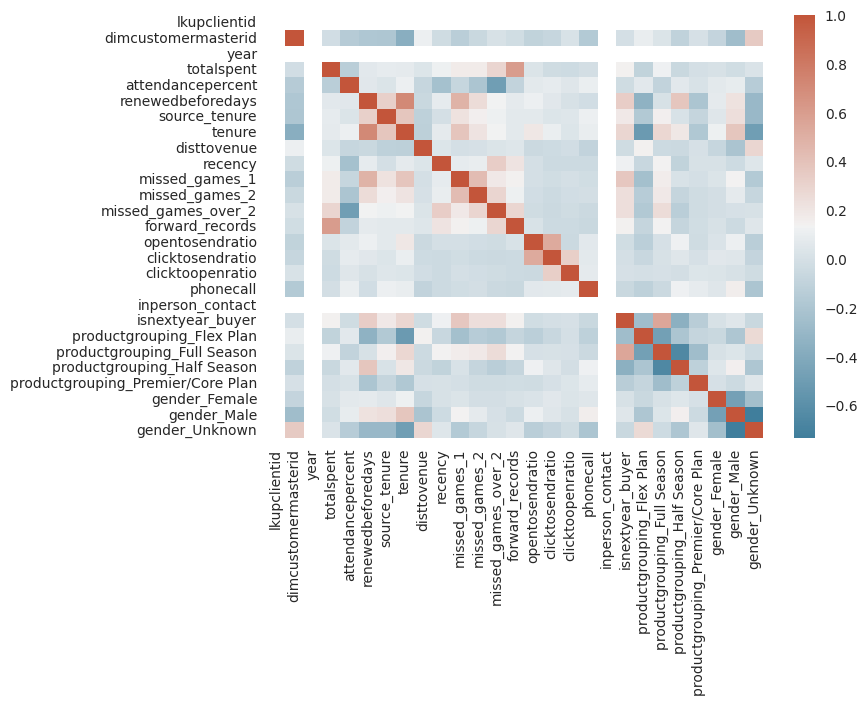

In [ ]:
corr = df_encoded.corr()

cmap = sns.diverging_palette(230, 20, as_cmap=True)

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap=cmap)

In [ ]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th tr",
                 props=[("font-size", "12pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())\
    .set_sticky(axis="index")

,lkupclientid,dimcustomermasterid,year,totalspent,attendancepercent,renewedbeforedays,source_tenure,tenure,disttovenue,recency,missed_games_1,missed_games_2,missed_games_over_2,forward_records,opentosendratio,clicktosendratio,clicktoopenratio,phonecall,inperson_contact,isnextyear_buyer,productgrouping_Flex Plan,productgrouping_Full Season,productgrouping_Half Season,productgrouping_Premier/Core Plan,gender_Female,gender_Male,gender_Unknown
lkupclientid,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
dimcustomermasterid,nan,1.00,nan,-0.02,-0.15,-0.19,-0.19,-0.37,0.11,-0.04,-0.13,-0.06,0.01,-0.03,-0.10,-0.07,0.02,-0.17,nan,-0.01,0.09,0.03,-0.11,-0.00,-0.09,-0.26,0.35
year,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
totalspent,nan,-0.02,nan,1.00,-0.13,0.06,0.08,0.08,0.03,0.11,0.17,0.17,0.29,0.60,0.03,-0.03,-0.04,-0.01,nan,0.15,-0.10,0.13,-0.06,-0.00,0.01,-0.02,0.02
attendancepercent,nan,-0.15,nan,-0.13,1.00,0.05,0.03,0.11,-0.07,-0.24,-0.08,-0.20,-0.49,-0.10,0.07,0.08,0.05,0.10,nan,-0.03,0.06,-0.10,0.06,0.01,0.07,0.09,-0.15
renewedbeforedays,nan,-0.19,nan,0.06,0.05,1.00,0.32,0.72,-0.06,0.08,0.48,0.25,0.13,0.07,0.11,0.06,0.01,-0.02,nan,0.33,-0.35,0.01,0.38,-0.20,0.08,0.22,-0.30
source_tenure,nan,-0.19,nan,0.08,0.03,0.32,1.00,0.38,-0.12,-0.01,0.22,0.15,0.12,0.07,0.07,0.03,0.04,0.11,nan,0.18,-0.18,0.15,0.01,-0.08,0.05,0.24,-0.30
tenure,nan,-0.37,nan,0.08,0.11,0.72,0.38,1.00,-0.12,0.07,0.38,0.21,0.13,0.07,0.19,0.10,0.03,0.09,nan,0.28,-0.52,0.28,0.19,-0.18,0.11,0.37,-0.50
disttovenue,nan,0.11,nan,0.03,-0.07,-0.06,-0.12,-0.12,1.00,0.03,-0.01,-0.00,0.03,0.04,-0.06,-0.04,-0.02,-0.09,nan,-0.04,0.14,-0.05,-0.06,-0.00,-0.07,-0.21,0.29
recency,nan,-0.04,nan,0.11,-0.24,0.08,-0.01,0.07,0.03,1.00,0.08,0.09,0.33,0.21,-0.01,-0.04,-0.05,-0.05,nan,0.12,-0.07,0.13,-0.10,0.00,0.01,-0.04,0.04


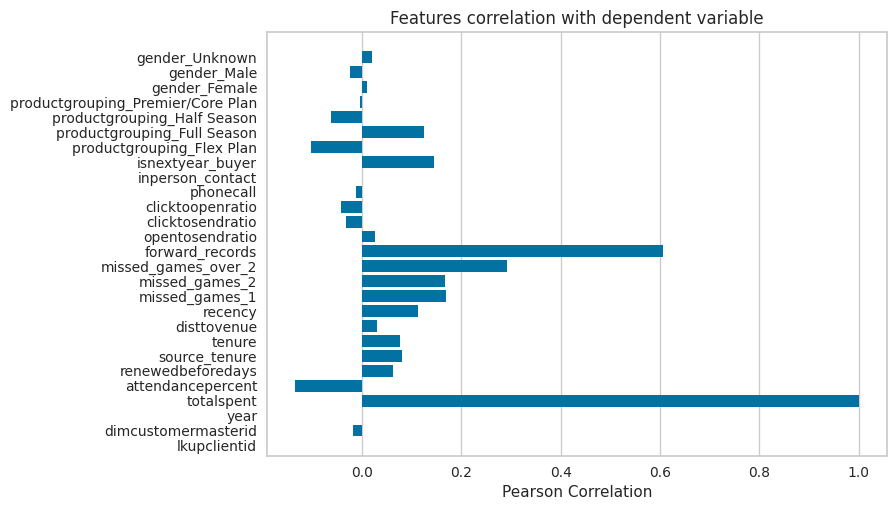

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [ ]:
from yellowbrick.target import FeatureCorrelation

feature_names = []

visualizer = FeatureCorrelation(labels=df_encoded.columns)
visualizer.fit(df_encoded, df_encoded["totalspent"])
visualizer.poof()

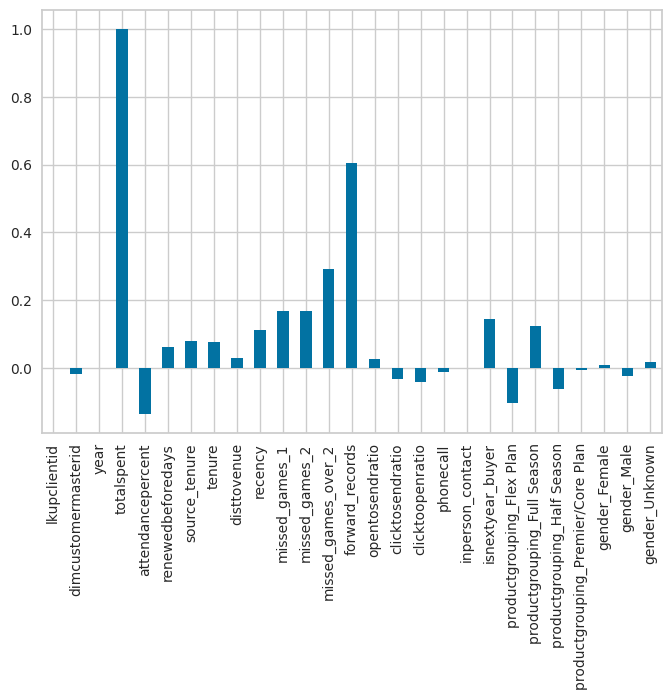

In [ ]:
fig = corr["totalspent"].plot(kind="bar")

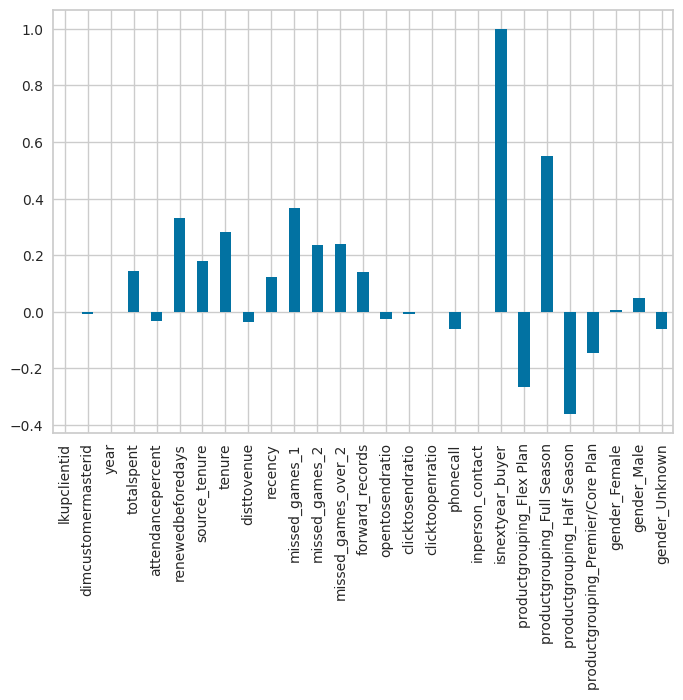

In [ ]:
fig = corr["isnextyear_buyer"].plot(kind="bar")

In [153]:
test = corr.where(np.ones(corr.shape).astype(np.bool))
corr_stack = test.stack().reset_index()
corr_stack.columns = ["Row", "Column", "Value"]
corr_stack.head()

,Row,Column,Value
0,dimcustomermasterid,dimcustomermasterid,1.000000
1,dimcustomermasterid,totalspent,-0.018759
2,dimcustomermasterid,attendancepercent,-0.153734
3,dimcustomermasterid,renewedbeforedays,-0.192146
4,dimcustomermasterid,source_tenure,-0.193437


<AxesSubplot:xlabel='Value', ylabel='Column'>

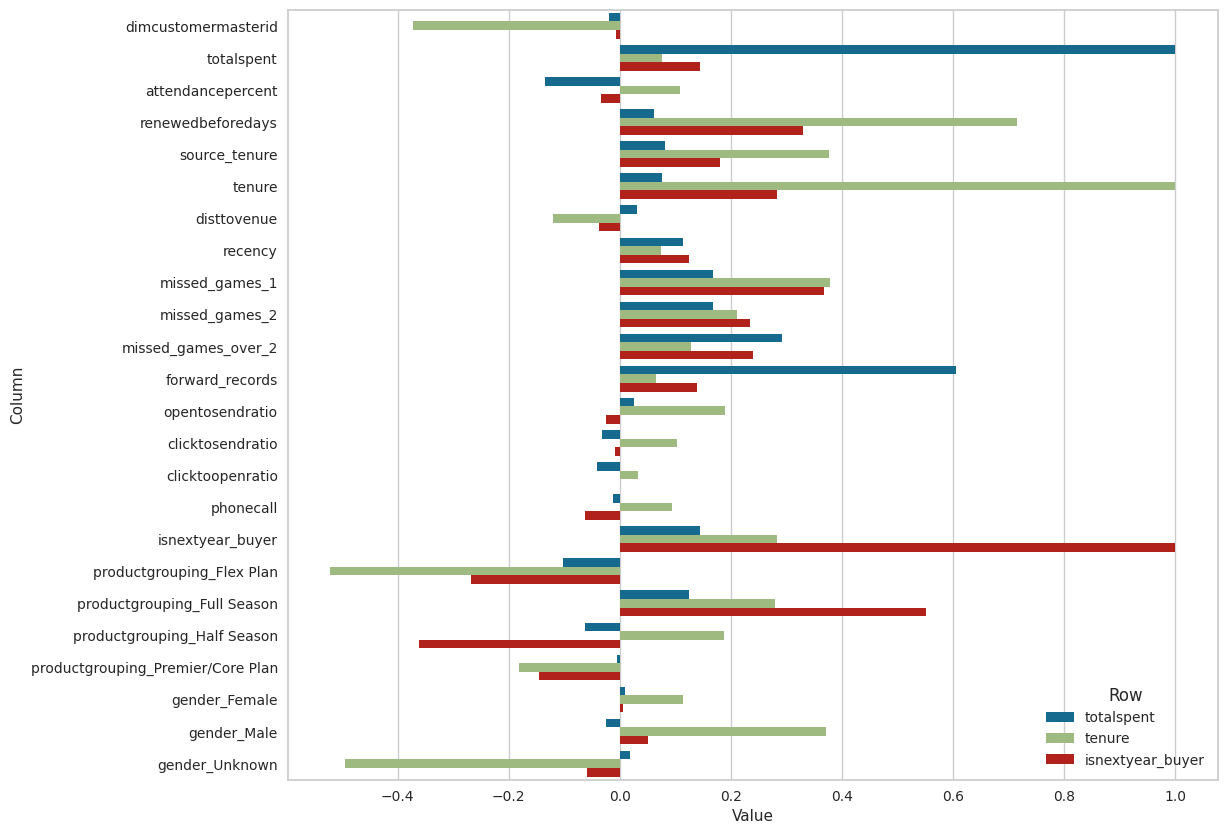

In [154]:
corr_targets = corr_stack[(corr_stack["Row"] == "isnextyear_buyer") | (corr_stack["Row"] == "totalspent") | (corr_stack["Row"] == "tenure")]

plt.figure(figsize=(12,10))
sns.barplot(data=corr_targets, x=corr_stack["Value"], y=corr_targets["Column"], hue=corr_targets["Row"])
